In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn keras keras-tuner tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from keras import layers, regularizers
import keras_tuner as kt

In [ ]:
df = pd.read_csv('balanced_dataset.csv')
print(df.isnull().sum())
print(df.describe())


City       0
PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
AQI        0
dtype: int64
              PM2.5          PM10            NO           NO2           NOx  \
count  13993.000000  13993.000000  13993.000000  13993.000000  13993.000000   
mean      59.908393    122.075805     17.141790     33.596466     35.625192   
std       51.710484     81.419499     22.851014     21.035980     33.730667   
min        1.720000      0.210000      0.400000      0.010000      0.000000   
25%       29.600000     74.590000      5.753491     18.210000     16.370000   
50%       46.440000    103.220000      9.433089     29.132296     25.540000   
75%       69.750000    140.820000     16.890000     43.009270     41.010000   
max      685.360000    796.880000    221.030000    162.500000    293.100000   

                NH3            CO           SO2            O3       Benzene  \
count  13993.000000  13993.

In [ ]:
# Check for missing values
print(df.isnull().sum())
# Basic statistics
df.describe()

City       0
PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
AQI        0
dtype: int64


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
count,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000
mean,59.908393,122.075805,17.141790,33.596466,35.625192,27.571431,1.116699,9.984700,38.073336,3.709960,9.310697,138.762095
std,51.710484,81.419499,22.851014,21.035980,33.730667,26.892597,1.833690,6.713632,21.019884,7.589564,12.126727,90.293933
min,1.720000,0.210000,0.400000,0.010000,0.000000,0.020000,0.000000,0.710000,0.100000,0.000000,0.000000,20.000000
25%,29.600000,74.590000,5.753491,18.210000,16.370000,12.651964,0.580000,5.460000,23.529717,0.660000,2.126842,79.000000
50%,46.440000,103.220000,9.433089,29.132296,25.540000,22.600000,0.838495,8.510000,34.530000,1.690000,5.880000,110.000000
75%,69.750000,140.820000,16.890000,43.009270,41.010000,32.100000,1.130000,12.550000,48.190369,4.120000,11.423003,163.000000
max,685.360000,796.880000,221.030000,162.500000,293.100000,352.890000,48.070000,71.560000,257.730000,391.880000,411.520000,737.000000


In [ ]:
X = df.drop(['City', 'AQI'], axis=1).values
y = df['AQI'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalize target
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Reshape for LSTM
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data for final testing
X_train_full, X_test, y_train_full, y_test = train_test_split(X_lstm, y_scaled, test_size=0.1, random_state=42)

In [ ]:
def build_lstm_model(hp):
    model = keras.Sequential()

    for i in range(hp.Int("num_layers", 1, 2)):
        return_seq = (i < hp.Int("num_layers", 1, 2) - 1)
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', 32, 128, step=32),
            return_sequences=return_seq,
            input_shape=(X_lstm.shape[1], X_lstm.shape[2]) if i == 0 else None,
            kernel_regularizer=regularizers.l2(hp.Choice('l2', [0.0, 1e-4, 1e-3]))
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_mae',
    max_trials=15,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='lstm_aqi_regression_v2'
)

tuner.search(X_train_full, y_train_full, epochs=20, validation_split=0.2, verbose=1,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)

Trial 15 Complete [00h 00m 53s]
val_mae: 0.19708189368247986

Best val_mae So Far: 0.18522989749908447
Total elapsed time: 00h 10m 08s
Best hyperparameters: {'num_layers': 2, 'units_0': 128, 'l2': 0.0, 'dropout_0': 0.30000000000000004, 'lr': 0.001, 'units_1': 64, 'dropout_1': 0.30000000000000004}


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
histories, fold_metrics = [], []
best_val_mae = float('inf')
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full, y_train_full)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = build_lstm_model(best_hp)

    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_sched = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=best_hp.values.get('batch_size', 32),
        callbacks=[es, lr_sched],
        verbose=1
    )

    histories.append(history)

    y_pred = model.predict(X_val).flatten()
    y_val_inv = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
    y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_val_inv, y_pred_inv)
    mse = mean_squared_error(y_val_inv, y_pred_inv)
    r2 = r2_score(y_val_inv, y_pred_inv)

    fold_metrics.append({'mae': mae, 'mse': mse, 'r2': r2, 'y_val': y_val_inv, 'y_pred': y_pred_inv})

    val_mae = min(history.history['val_mae'])
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model = model
        model.save('best_lstm_aqi_model.h5')


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3536 - mae: 0.3933 - val_loss: 0.0934 - val_mae: 0.2020 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1139 - mae: 0.2244 - val_loss: 0.0870 - val_mae: 0.1953 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1055 - mae: 0.2170 - val_loss: 0.0847 - val_mae: 0.1925 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1023 - mae: 0.2143 - val_loss: 0.0830 - val_mae: 0.1927 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1053 - mae: 0.2141 - val_loss: 0.0835 - val_mae: 0.1935 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1052 - mae: 0.2151 - val_loss: 0.0858 - val_mae: 0.1963 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1063 - mae: 0.2140 - val_loss: 0.0818 - val_mae: 0.1885 - learning_rate: 5.0000e-04
E


--- Fold 2 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.3351 - mae: 0.3866 - val_loss: 0.1097 - val_mae: 0.2121 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1036 - mae: 0.2189 - val_loss: 0.1107 - val_mae: 0.2093 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0978 - mae: 0.2149 - val_loss: 0.1079 - val_mae: 0.2094 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0960 - mae: 0.2100 - val_loss: 0.1088 - val_mae: 0.2036 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0968 - mae: 0.2090 - val_loss: 0.1048 - val_mae: 0.2008 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0972 - mae: 0.2069 - val_loss: 0.1036 - val_mae: 0.2052 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0952 - mae: 0.2053 - val_loss: 0.1038 - val_mae: 0.2038 - learning_rate: 0.0010
Epoch 8/50
315/3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.3647 - mae: 0.3945 - val_loss: 0.0851 - val_mae: 0.1955 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1035 - mae: 0.2193 - val_loss: 0.0868 - val_mae: 0.1953 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1105 - mae: 0.2210 - val_loss: 0.0846 - val_mae: 0.1933 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1049 - mae: 0.2140 - val_loss: 0.0892 - val_mae: 0.2034 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0986 - mae: 0.2117 - val_loss: 0.0827 - val_mae: 0.1899 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1019 - mae: 0.2154 - val_loss: 0.0847 - val_mae: 0.1951 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0999 - mae: 0.2121 - val_loss: 0.0839 - val_mae: 0.1959 - learning_rate: 0.0010
Epoch 8/50
315/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.3304 - mae: 0.3792 - val_loss: 0.1100 - val_mae: 0.2114 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1016 - mae: 0.2144 - val_loss: 0.1057 - val_mae: 0.2092 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1015 - mae: 0.2118 - val_loss: 0.1039 - val_mae: 0.2071 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1004 - mae: 0.2142 - val_loss: 0.1033 - val_mae: 0.2065 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1037 - mae: 0.2143 - val_loss: 0.1054 - val_mae: 0.2078 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0931 - mae: 0.2058 - val_loss: 0.1002 - val_mae: 0.2016 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0942 - mae: 0.2065 - val_loss: 0.1021 - val_mae: 0.2049 - learning_rate: 0.0010
Epoch 8/50
315/3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3751 - mae: 0.4016 - val_loss: 0.0906 - val_mae: 0.1953 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1149 - mae: 0.2262 - val_loss: 0.0852 - val_mae: 0.1896 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1061 - mae: 0.2187 - val_loss: 0.0833 - val_mae: 0.1884 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0954 - mae: 0.2099 - val_loss: 0.0848 - val_mae: 0.1947 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1072 - mae: 0.2195 - val_loss: 0.0822 - val_mae: 0.1909 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1024 - mae: 0.2166 - val_loss: 0.0844 - val_mae: 0.1922 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1071 - mae: 0.2139 - val_loss: 0.0820 - val_mae: 0.1908 - learning_rate: 0.0010
Epoch 8/50
315/

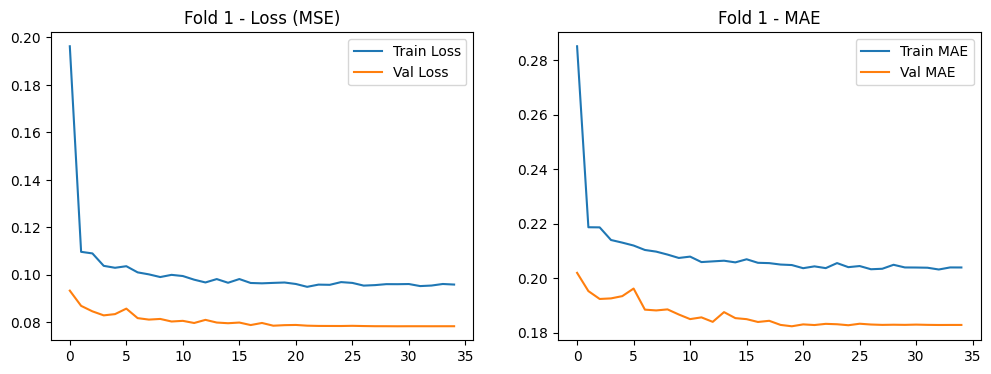

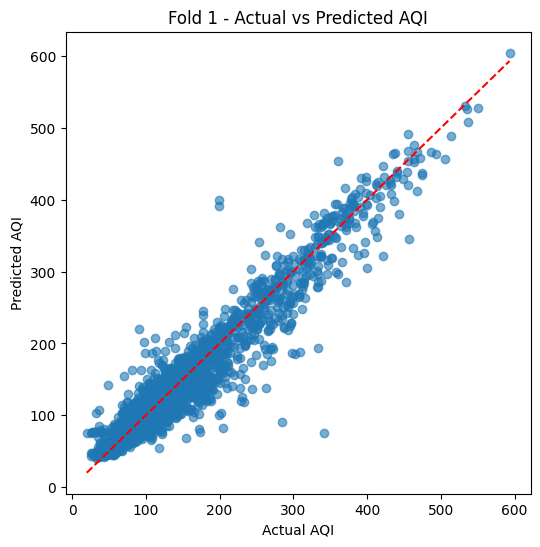

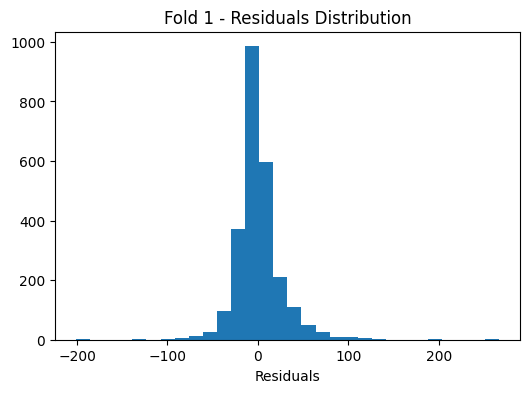

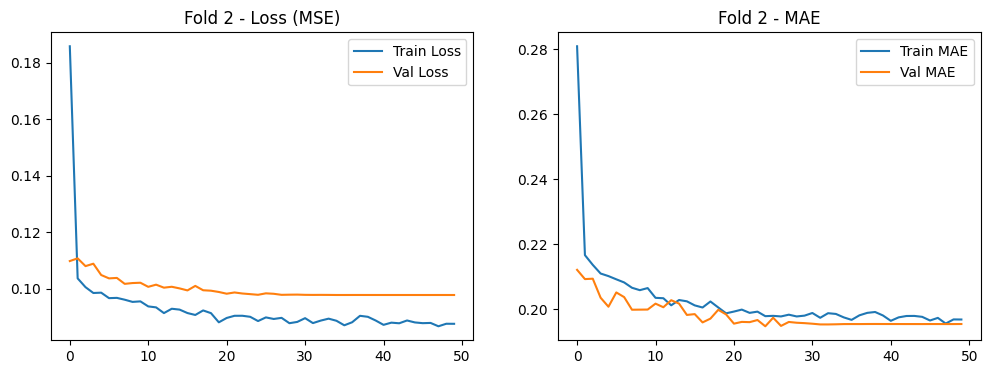

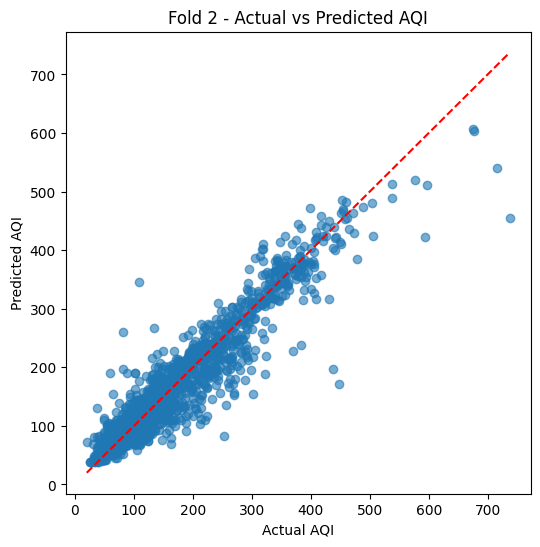

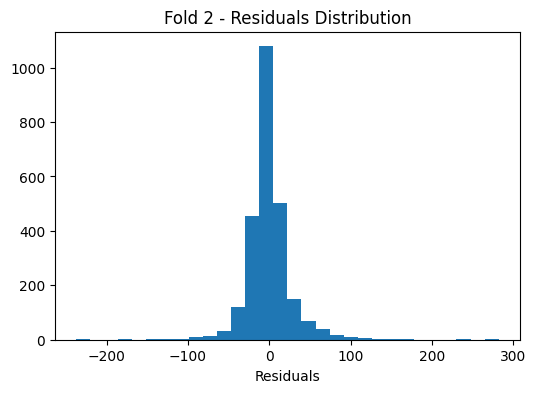

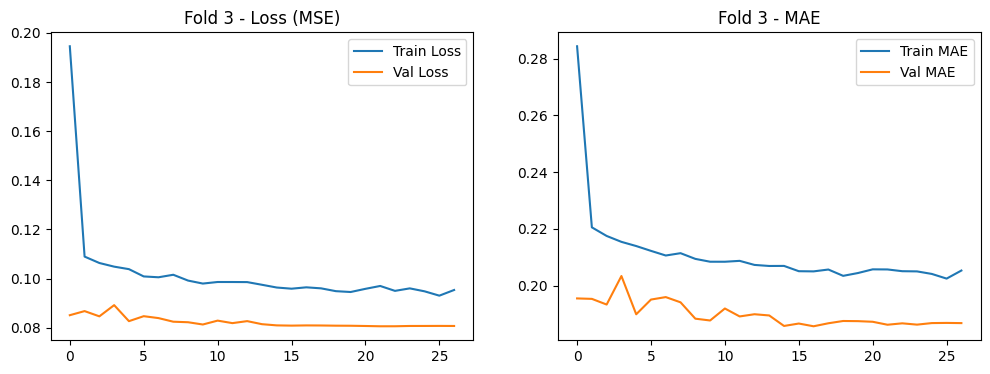

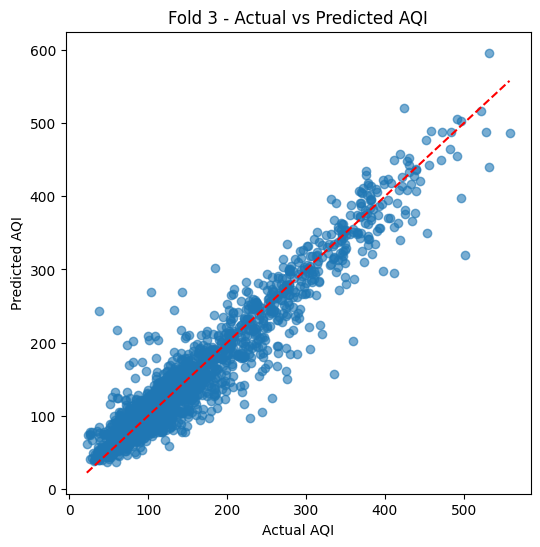

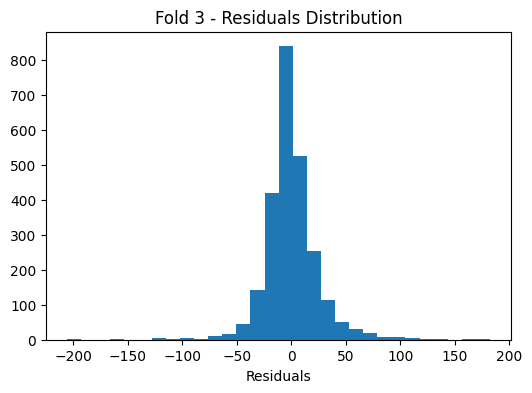

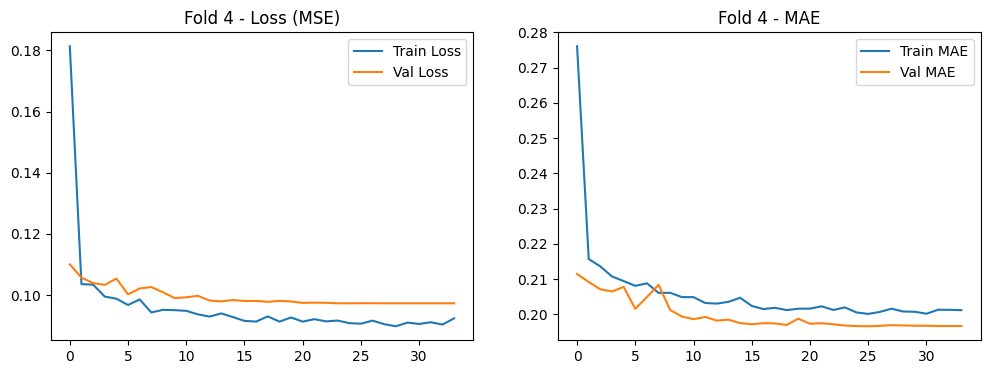

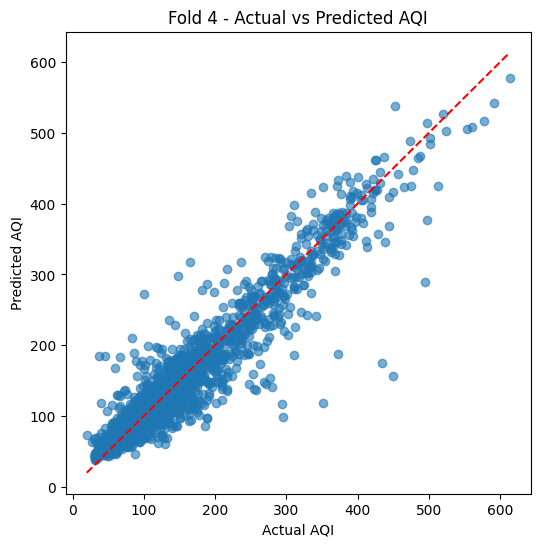

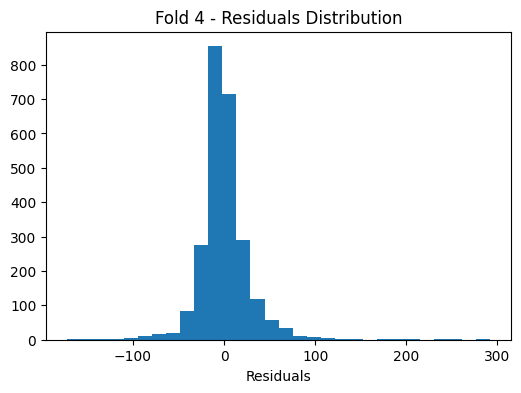

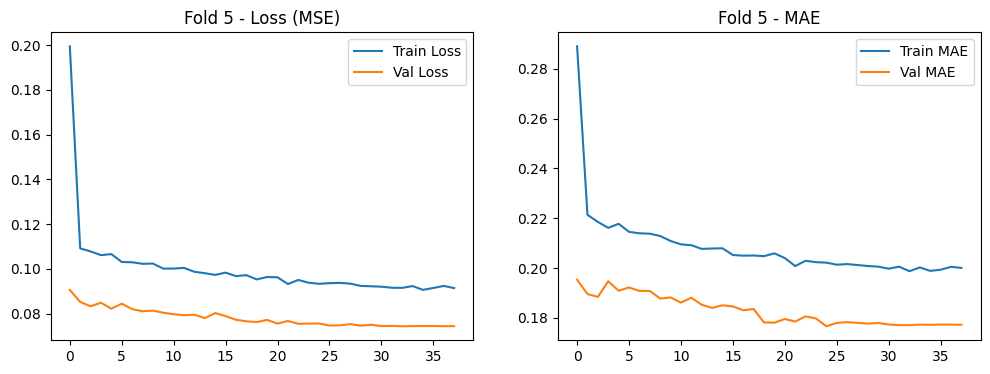

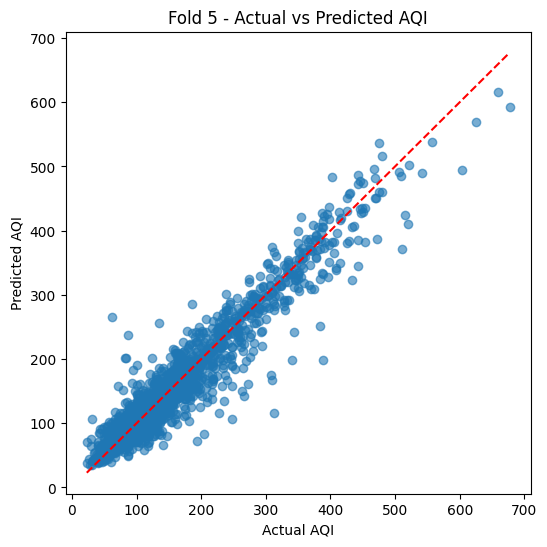

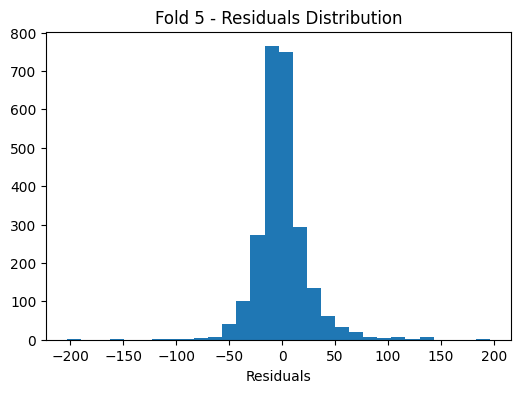

In [ ]:
for i, (history, metrics) in enumerate(zip(histories, fold_metrics)):
    # Loss & MAE
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss (MSE)')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'Fold {i+1} - MAE')
    plt.legend()
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(6,6))
    plt.scatter(metrics['y_val'], metrics['y_pred'], alpha=0.6)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'Fold {i+1} - Actual vs Predicted AQI')
    plt.plot([metrics['y_val'].min(), metrics['y_val'].max()], [metrics['y_val'].min(), metrics['y_val'].max()], 'r--')
    plt.show()

    # Residuals
    plt.figure(figsize=(6,4))
    plt.hist(metrics['y_val'] - metrics['y_pred'], bins=30)
    plt.xlabel('Residuals')
    plt.title(f'Fold {i+1} - Residuals Distribution')
    plt.show()

In [ ]:
# Aggregate results
maes = [m['mae'] for m in fold_metrics]
mses = [m['mse'] for m in fold_metrics]
r2s = [m['r2'] for m in fold_metrics]

print(f'Average MAE: {np.mean(maes):.4f} ± {np.std(maes):.4f}')
print(f'Average MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}')
print(f'Average R²: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}')

# Final Test Evaluation
final_preds = best_model.predict(X_test).flatten()
final_preds_inv = y_scaler.inverse_transform(final_preds.reshape(-1,1)).flatten()
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

print("\nFinal Test Set Evaluation:")
print("MAE:", mean_absolute_error(y_test_inv, final_preds_inv))
print("MSE:", mean_squared_error(y_test_inv, final_preds_inv))
print("R²:", r2_score(y_test_inv, final_preds_inv))

Average MAE: 16.9484 ± 0.6771
Average MSE: 698.2398 ± 80.4718
Average R²: 0.9143 ± 0.0087
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Test Set Evaluation:
MAE: 16.475009741101946
MSE: 648.1204270134224
R²: 0.9216517086035991
